In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.feature_selection import SelectKBest, f_classif
import marsilea as ma
import marsilea.plotter as mp
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from marsilea.plotter import Colors, Title
from matplotlib.patches import Patch, Rectangle
from matplotlib.colors import Normalize

sys.path.append("../../Utils")
from loaders import HNSCCFeatureHandler

METADATA_PATH = "../../Supplementary_Tables/ST1/RAW_HNSCC_METADATA_NEW.csv"
VALID_IDS_PATH = "../../Utils/Lists/grouped.txt"
HOLD_IDS_PATH = '../../Utils/Lists/holdout_ids.txt'

hc_data = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH, HOLD_IDS_PATH)
_ = hc_data.load_feature_to_dataframe("../../Data/*.hg38.frag.interval_mds.tsv", 0, 4)
z = hc_data.normalize_zscore()
_ = hc_data.merge_feature_metadata()
z = hc_data.batch_correct()

In [17]:
patients_full = '../../Utils/Lists/grouped.txt'
with open(patients_full, 'r') as file:
    patients_full = file.readlines()
patients_full = [line.strip() for line in patients_full]

In [18]:
def process_data(path, patient_list_path, suffix):
    with open(patient_list_path, 'r') as file:
        patients_full = [line.strip() for line in file.readlines()]
    
    data = hc_data.get_subset(patients_full, df=hc_data.filter_locations(path))
    data = data[[col for col in data.columns if ':' in col or (suffix == '_SCREEN' and col == "Treatment Response") or (suffix == '_SCREEN' and col == "Stratification")]]
    data = data.reset_index(drop=True)
    data.columns = [f"{col}{suffix}" for col in data.columns]
    return data

path = 'F2C.Differential_rMDS.bed'
data_sources = [
    ('../../Utils/Lists/screen_grouped.txt', '_SCREEN'),
    ('../../Utils/Lists/day0_grouped.txt', '_DAY0'),
    ('../../Utils/Lists/adjwk1_grouped.txt', '_ADJWK1')
]

processed_data = [process_data(path, p[0], p[1]) for p in data_sources]
DATA = pd.concat(processed_data, axis=1)

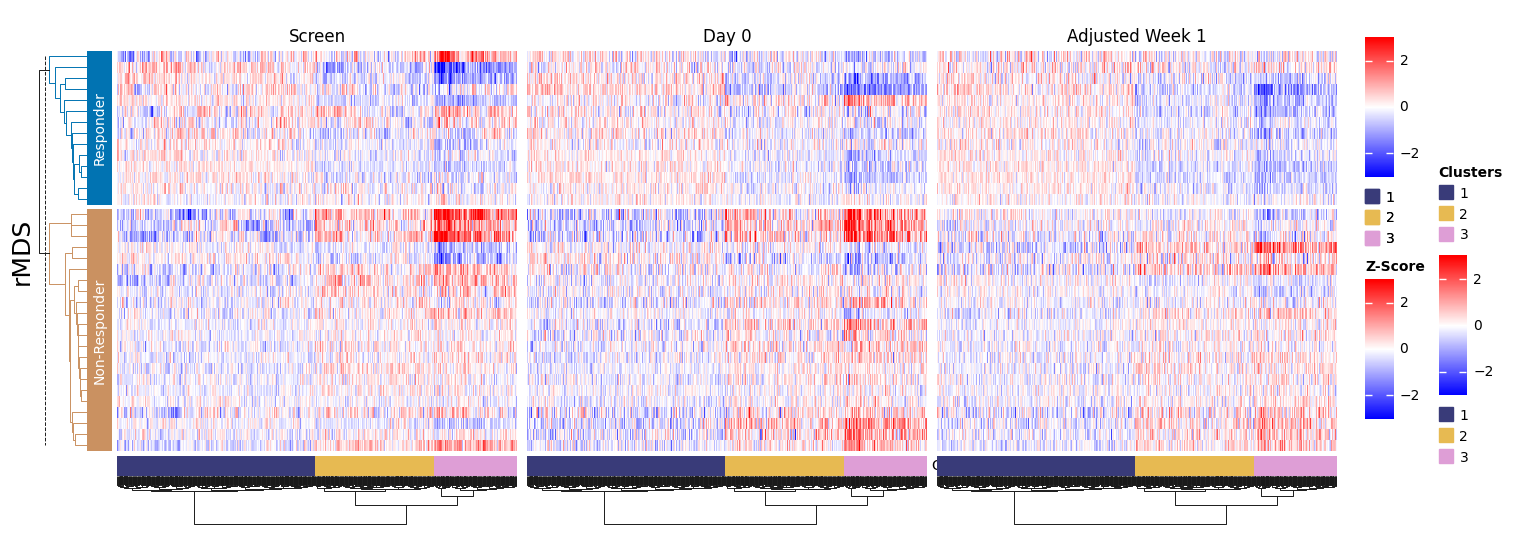

In [19]:
df = DATA

screen_data = df.filter(like='_SCREEN')
day0_data = df.filter(like='_DAY0')
adjwk1_data = df.filter(like='_ADJWK1')

screen_data.columns = [col.replace('_SCREEN', '') for col in screen_data.columns]
day0_data.columns = [col.replace('_DAY0', '') for col in day0_data.columns]
adjwk1_data.columns = [col.replace('_ADJWK1', '') for col in adjwk1_data.columns]

treatment_response = screen_data['Treatment Response']
stratification = screen_data['Stratification']
screen_data = screen_data.filter(like=':')
day0_data = day0_data.filter(like=':')
adjwk1_data = adjwk1_data.filter(like=':')

combined_data = pd.concat([screen_data, day0_data, adjwk1_data], axis=1)

colors = sns.color_palette('colorblind', 10)
treatment_palette = [colors[0], colors[5]]
response_colors = pd.Series(treatment_response).map(dict(zip(treatment_response.unique(), treatment_palette)))

responder_data = combined_data[treatment_response == 'Responder']
non_responder_data = combined_data[treatment_response == 'Non-Responder']

responder_linkage = linkage(responder_data, method='ward')
non_responder_linkage = linkage(non_responder_data, method='ward')

row_Z = {
    'Responder': responder_linkage,
    'Non-Responder': non_responder_linkage
}

link_col = pd.concat([screen_data, day0_data, adjwk1_data], axis=0)
col_Z = linkage(screen_data.T, method='ward')
col_order = dendrogram(col_Z, no_plot=True)['leaves']
clusters = fcluster(col_Z, t=3, criterion='maxclust')

h1 = ma.Heatmap(screen_data, cmap="bwr", vmax=3, vmin=-3)
h1.group_rows(treatment_response, order=["Responder", "Non-Responder"])
h1.add_left(mp.Chunk(["Responder", "Non-Responder"], treatment_palette), pad=0.05)
h1.add_dendrogram("left", colors=treatment_palette, linkage=row_Z)
color = Colors(clusters, cmap='tab20b')
h1.add_bottom(color, size=0.2, pad=0.05)
h1.add_dendrogram("bottom", linkage=col_Z)
title = Title(f"rMDS", align='center', fontsize=18)
h1.add_left(title, size=0.2, pad=0.05)
h1.add_legends()
h1.add_title(top="Screen")

h2 = ma.Heatmap(day0_data, cmap="bwr", vmax=3, vmin=-3, label="Z-Score")
h2.group_rows(treatment_response, order=["Responder", "Non-Responder"])
h2.add_dendrogram("left", colors=treatment_palette, linkage=row_Z, show=False)
color = Colors(clusters, label="Clusters", cmap='tab20b')
h2.add_bottom(color, size=0.2, pad=0.05)
h2.add_dendrogram("bottom", linkage=col_Z)
h2.add_title(top="Day 0")

h3 = ma.Heatmap(adjwk1_data, cmap="bwr", vmax=3, vmin=-3)
h3.group_rows(treatment_response, order=["Responder", "Non-Responder"])
color = Colors(stratification, label="Risk\nStratification", cmap='tab20')
color = Colors(clusters, cmap='tab20b')
h3.add_bottom(color, size=0.2, pad=0.05)
h3.add_dendrogram("left", colors=treatment_palette, linkage=row_Z, show=False)
h3.add_dendrogram("bottom", linkage=col_Z, )
h3.add_title(top="Adjusted Week 1")

c = (h1 + .1 + h2 + .1 + h3)
c.add_legends()
c.render()

c.save('F2D.rMDS.pdf', dpi=600)

In [20]:
for cluster_num in [1, 2, 3]:
    screen_data_cluster = screen_data.iloc[:, clusters == cluster_num]
    day0_data_cluster = day0_data.iloc[:, clusters == cluster_num]
    adjwk1_data_cluster = adjwk1_data.iloc[:, clusters == cluster_num]
    parsed_data = [[
        column.split(':')[0],
        int(column.split(':')[1].split('-')[0]),
        int(column.split(':')[1].split('-')[1])
    ] for column in adjwk1_data_cluster.columns]
    
    df = pd.DataFrame(parsed_data)
    df.to_csv(f'../../Supplementary_Tables/ST3/rMDS_cluster{cluster_num}.tsv', sep='\t', index=False, header=False)
    
    combined_data = pd.concat(
        [screen_data_cluster.mean(axis=1),
         day0_data_cluster.mean(axis=1),
         adjwk1_data_cluster.mean(axis=1),
         treatment_response],
        axis=1
    )
    combined_data.columns = ['Screen', 'Day 0', 'Adjusted Week 1', 'Treatment Response']
    combined_data['Treatment Response'] = combined_data['Treatment Response'].astype('category')

    combined_data_melted = combined_data.reset_index().melt(
        id_vars=['Treatment Response'],
        value_vars=['Screen', 'Day 0', 'Adjusted Week 1'],
        var_name='Timepoint',
        value_name='Value'
    )
    
    colors = sns.color_palette('colorblind', 10)
    treatment_palette = [colors[0], colors[5]]
    hue_order = ['Responder', 'Non-Responder']
    
    plt.figure(figsize=(4, 4), dpi=300)
    sns.lineplot(
        data=combined_data_melted,
        x='Timepoint', y='Value', hue='Treatment Response',
        marker='o', estimator='mean', ci=95,
        palette=treatment_palette, hue_order=hue_order
    )

    plt.xlabel('Blood Sample Timepoint')
    plt.ylabel("Mean Z-Score Across\nCluster's Genomic Bins")
    plt.title(f'Cluster {cluster_num}')
    plt.xticks(ticks=[0, 1, 2], labels=['Screen', 'Day 0', 'Adjusted\nWeek 1'])
    plt.ylim(-0.75,0.75)
    plt.yticks(ticks=[-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])
    plt.legend(title=None, loc='upper right', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(f'F2D.rMDS.C{cluster_num}.pdf', dpi=600)
    plt.close()
